In [ ]:
cd /content/drive/My Drive/Colab Notebooks/esrgan

/content/drive/My Drive/Colab Notebooks/esrgan


In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from models import *
from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
os.makedirs("images/training", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

In [ ]:
cfg = {}
cfg["epoch"] = 0
cfg["n_epochs"] = 20
cfg["dataset_name"] = "/content/drive/My Drive/Colab Notebooks/esrgan/archive/training_data/training_data/images"
cfg["batch_size"] = 4
cfg["lr"] = 0.0002
cfg["b1"] = 0.9
cfg['b2'] = 0.999
cfg["decay_epoch"] = 100
cfg["n_cpu"] = 8
cfg["hr_height"] = 224
cfg["hr_width"] = 224
cfg["channels"] = 3
cfg["sample_interval"] = 5000
cfg["checkpoint_interval"] = 20
cfg["residual_blocks"] = 23
cfg["warmup_batches"] = 500
cfg["lambda_adv"] = 5e-3
cfg["lambda_pixel"] = 1e-2
cfg

{'b1': 0.9,
 'b2': 0.999,
 'batch_size': 4,
 'channels': 3,
 'checkpoint_interval': 20,
 'dataset_name': '/content/drive/My Drive/Colab Notebooks/esrgan/archive/training_data/training_data/images',
 'decay_epoch': 100,
 'epoch': 0,
 'hr_height': 224,
 'hr_width': 224,
 'lambda_adv': 0.005,
 'lambda_pixel': 0.01,
 'lr': 0.0002,
 'n_cpu': 8,
 'n_epochs': 20,
 'residual_blocks': 23,
 'sample_interval': 5000,
 'warmup_batches': 500}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hr_shape = (cfg["hr_height"], cfg["hr_width"])

In [ ]:
generator = GeneratorRRDB(cfg["channels"], filters=64, num_res_blocks=cfg["residual_blocks"]).to(device)
discriminator = Discriminator(input_shape=(cfg["channels"], *hr_shape)).to(device)
feature_extractor = FeatureExtractor().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
feature_extractor.eval()

FeatureExtractor(
  (vgg19_54): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride

In [ ]:
criterion_GAN = torch.nn.BCEWithLogitsLoss().to(device)
criterion_content = torch.nn.L1Loss().to(device)
criterion_pixel = torch.nn.L1Loss().to(device)

In [ ]:
if cfg["epoch"] != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth" % cfg["epoch"]))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth" % cfg["epoch"]))

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=cfg["lr"], betas=(cfg["b1"], cfg["b2"]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=cfg["lr"], betas=(cfg["b1"], cfg["b2"]))
scheduler_G = StepLR(optimizer_G, step_size=2e+5, gamma=0.1)
scheduler_D = StepLR(optimizer_D, step_size=2e+5, gamma=0.1)

In [ ]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

In [ ]:
dataloader = DataLoader(
    ImageDataset(cfg["dataset_name"], hr_shape=hr_shape),
    batch_size=cfg["batch_size"],
    shuffle=True,
    num_workers= cfg["n_cpu"],
)

In [ ]:
loss_G_list_epoch = []
loss_D_list_epoch = []

for epoch in range(cfg["epoch"], cfg["n_epochs"]):
    epoch_G = []
    epoch_D = []
    for i, imgs in enumerate(dataloader):
    
        batches_done = epoch * len(dataloader) + i

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Measure pixel-wise loss against ground truth
        loss_pixel = criterion_pixel(gen_hr, imgs_hr)

        if batches_done < cfg["warmup_batches"]:
            # Warm-up (pixel-wise loss only)
            loss_pixel.backward()
            optimizer_G.step()
            print(
                "[Epoch %d/%d] [Batch %d/%d] [G pixel: %f]"
                % (epoch, cfg["n_epochs"], i, len(dataloader), loss_pixel.item())
            )
            continue

        # Extract validity predictions from discriminator
        pred_real = discriminator(imgs_hr).detach()
        pred_fake = discriminator(gen_hr)

        # Adversarial loss (relativistic average GAN)
        loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr).detach()
        loss_content = criterion_content(gen_features, real_features)

        # Total generator loss
        loss_G = loss_content + cfg["lambda_adv"] * loss_GAN + cfg["lambda_pixel"] * loss_pixel
        epoch_G.append(loss_G.item())

        loss_G.backward()
        optimizer_G.step()
        scheduler_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        pred_real = discriminator(imgs_hr)
        pred_fake = discriminator(gen_hr.detach())

        # Adversarial loss for real and fake images (relativistic average GAN)
        loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        epoch_D.append(loss_D.item())

        loss_D.backward()
        optimizer_D.step()
        scheduler_D.step()

        # --------------
        #  Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, content: %f, adv: %f, pixel: %f]"
            % (
                epoch,
                cfg["n_epochs"],
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_content.item(),
                loss_GAN.item(),
                loss_pixel.item(),
            )
        )

        if batches_done % cfg["sample_interval"] == 0:
            # Save image grid with upsampled inputs and ESRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            img_grid = denormalize(torch.cat((imgs_lr, gen_hr), -1))
            save_image(img_grid, "images/training/%d.png" % batches_done, nrow=1, normalize=False)

        if batches_done % cfg["checkpoint_interval"] == 0:
            # Save model checkpoints
            torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
            torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" %epoch)

    loss_G_list_epoch.append(sum(epoch_G) / len(epoch_G))
    loss_D_list_epoch.append(sum(epoch_D) / len(epoch_D))

ストリーミング出力は最後の 5000 行に切り捨てられました。
[Epoch 14/20] [Batch 623/937] [D loss: 0.000000] [G loss: 0.838793, content: 0.748080, adv: 17.584574, pixel: 0.279020]
[Epoch 14/20] [Batch 624/937] [D loss: 0.000000] [G loss: 0.857519, content: 0.765439, adv: 17.756241, pixel: 0.329871]
[Epoch 14/20] [Batch 625/937] [D loss: 0.000000] [G loss: 0.925531, content: 0.833360, adv: 17.831577, pixel: 0.301270]
[Epoch 14/20] [Batch 626/937] [D loss: 0.000000] [G loss: 0.878090, content: 0.786997, adv: 17.632248, pixel: 0.293164]
[Epoch 14/20] [Batch 627/937] [D loss: 0.000000] [G loss: 0.854773, content: 0.762834, adv: 17.758322, pixel: 0.314775]
[Epoch 14/20] [Batch 628/937] [D loss: 0.000000] [G loss: 0.898863, content: 0.807610, adv: 17.682863, pixel: 0.283798]
[Epoch 14/20] [Batch 629/937] [D loss: 0.000000] [G loss: 0.845278, content: 0.753087, adv: 17.841948, pixel: 0.298091]
[Epoch 14/20] [Batch 630/937] [D loss: 0.000000] [G loss: 0.893006, content: 0.802152, adv: 17.604458, pixel: 0.283170]
[Epoch 1

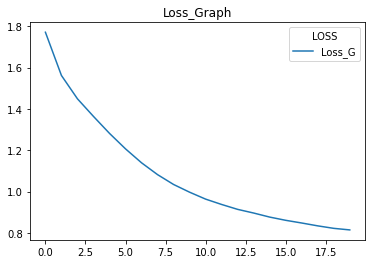

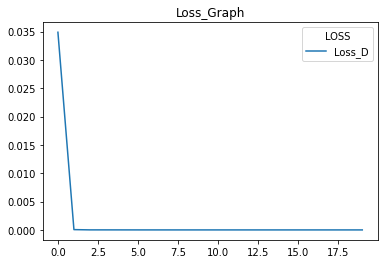

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Loss_Graph")
plt.plot(loss_G_list_epoch, label="Loss_G")
plt.legend(title='LOSS')
plt.show()

plt.title("Loss_Graph")
plt.plot(loss_D_list_epoch, label="Loss_D")
plt.legend(title='LOSS')
plt.show()